# Dense Profile Creation
Copy of `advanced_profile_creation-Dev` with dense profile creation code.

Assumes transportation routes, from the National Transportation Dataset, align well with elevation data, from the Best Available Topographic dataset.

### Author
John Wall (jwall@Dewberry.com)

### Import libraries

In [79]:
import pandas as pd
import geopandas as gpd
import shapely
from shapely import geometry, ops
from shapely.geometry import Point, LineString
import rasterio
from rasterio.plot import show
from matplotlib import pyplot as plt
from rasterstats import zonal_stats, point_query

### Load data

In [80]:
streams = "/mnt/c/gis/fcast_data/sample_streams.shp"
roads = "/mnt/c/gis/fcast_data/sample_roads.shp"
dem = "/mnt/c/gis/fcast_data/tiffs/c67567_aoi.tif"

### Create parallel lines from transportation routes

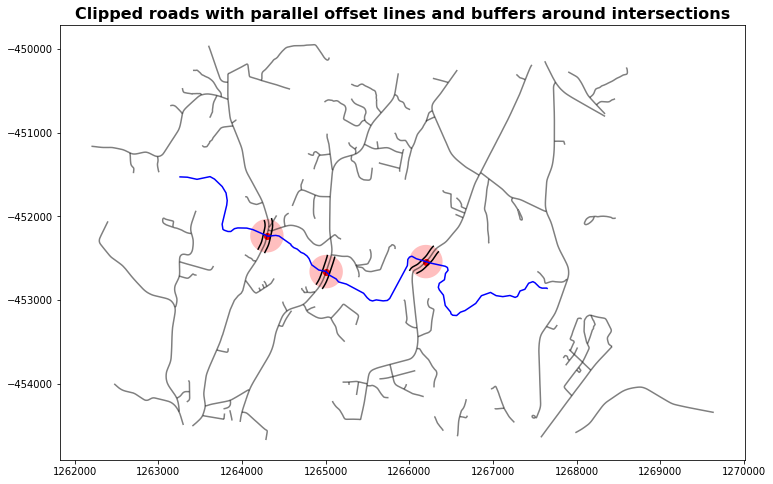

In [81]:
# Set variables based on GIS
# Offsets: Bess (45), Cos (14), Pue (10)
buffer_dist = 200
offset_dist = 45
our_prj = {'proj': 'aea', 'lat_1': 20, 'lat_2': 60, 'lat_0': 40,
             'lon_0': -96, 'x_0': 0, 'y_0': 0, 'ellps': 'GRS80',
             'units': 'm', 'no_defs': True}

# Code to execute
stream_prj = gpd.read_file(streams).to_crs(our_prj)
gdf_roads = gpd.read_file(roads).to_crs(our_prj)

# stream_prj = gdf_streams.to_crs(our_prj)
stream_shape = list(stream_prj.geometry)[0]
gdf_roads_diss = gdf_roads.dissolve(by='FULL_STREE')

intersecting_roads = gdf_roads_diss[gdf_roads_diss.geometry.apply(lambda row: stream_shape.intersects(row))].copy()
intersections = intersecting_roads.geometry.apply(lambda row: stream_shape.intersection(row))
intersection_buffers = intersections.buffer(buffer_dist)

clipped_roads = intersection_buffers.intersection(intersecting_roads)

single_lines = {}
for i, road in enumerate(clipped_roads):
    if type(road) is shapely.geometry.multilinestring.MultiLineString:
        single_lines[clipped_roads.index[i]] = ops.linemerge(road)
    else:
        single_lines[clipped_roads.index[i]] = road

# Resulting dictionary needs to be exploded due to roads with same
#     name. For example, if the road is an interstate.
explode_lines = gpd.GeoDataFrame(single_lines.items(), columns=['road','geometry'])
explode_lines = explode_lines.explode().droplevel(0).reset_index(0, drop=True)

# Possibly suboptimal method to create left and right offsets
df_list = []
for side in ['left', 'right']:
    explode_lines['side'] = side
    explode_lines['offset'] = explode_lines.geometry.apply(lambda road: road.parallel_offset(offset_dist, side, resolution=1))
    df_list.append(explode_lines.copy())
offset = pd.concat(df_list).reset_index(0, drop=True)

# Carry out some organization
offset['geometry'] = offset['offset']
offset.drop(columns=['offset'], inplace=True)

# Showcase the results
fig, ax = plt.subplots(figsize = (20,8))
offset.plot(color='k', ax=ax);
gdf_roads.plot(color='k', alpha=0.5, ax=ax);
stream_prj.plot(color='b', ax=ax);
intersections.plot(color='r', ax=ax);
intersection_buffers.plot(color='r', alpha=0.25, ax=ax);
ax.set_title("Clipped roads with parallel offset lines and buffers around intersections", fontsize=16, fontweight='bold');

In [82]:
def multi_to_single_lines(input_lines:gpd.geoseries.GeoSeries, column_name:str) -> gpd.geodataframe.GeoDataFrame:
    """Ensures all lines are single part linestrings"""
    single_lines = {}
    for i, line in enumerate(input_lines):
        if type(line) is shapely.geometry.multilinestring.MultiLineString:
            single_lines[input_lines.index[i]] = ops.linemerge(line)
        else:
            single_lines[input_lines.index[i]] = line
    
    out_gdf = gpd.GeoDataFrame(single_lines.items(), columns=[column_name ,'geometry'])
    
    return out_gdf

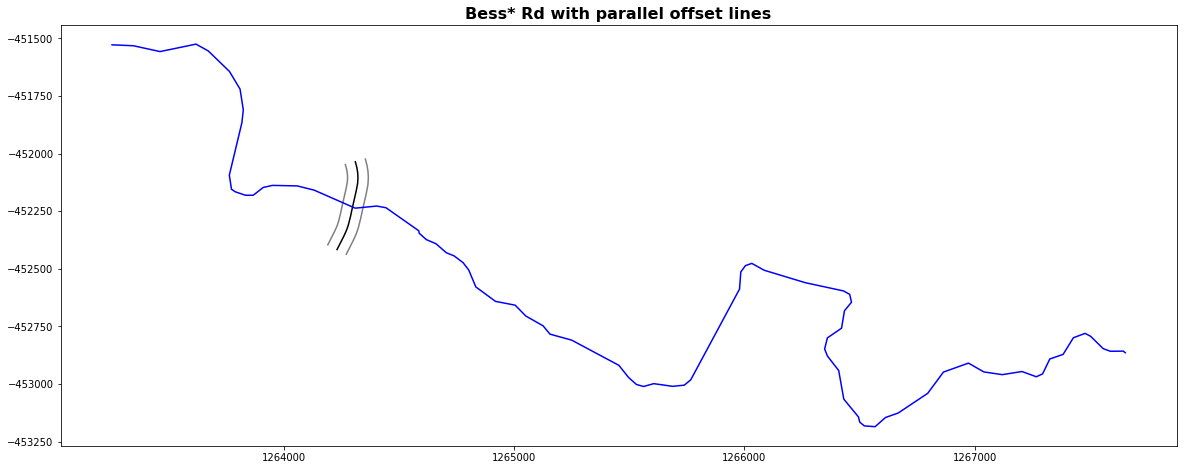

In [83]:
# Set variables
rough_name = 'Bess'
new_column_name = 'road'

# Usure all roads are single lines and select out the Bess* one
single_line_gdf = multi_to_single_lines(clipped_roads, new_column_name)
single_road = single_line_gdf[single_line_gdf[new_column_name].str.contains(rough_name)]
offset_lines = offset[offset['road'].str.contains(rough_name)]

# Showcase the results for Bess* road
fig, ax = plt.subplots(figsize = (20,8))
single_road.plot(color='k', ax=ax);
offset_lines.plot(color='k', alpha=0.5, ax=ax); # Inline sampling
stream_prj.plot(color='b', ax=ax);
ax.set_title("{}* Rd with parallel offset lines".format(rough_name),
             fontsize=16, fontweight='bold');

In [84]:
def get_topo_from_line(line:str, dem:str) -> pd.core.frame.DataFrame:
    """Identifies the elevation of a point from a shapely linestring from
        a digital elevation model.
    """
    profile = point_query(line, dem)

    vertecies = [Point(coord) for coord in line.coords]
    df = pd.DataFrame(vertecies, columns=['point'])
    df['elev'] = profile[0]
    df['lat'] = df.point.apply(lambda point: point.y)
    
    return df

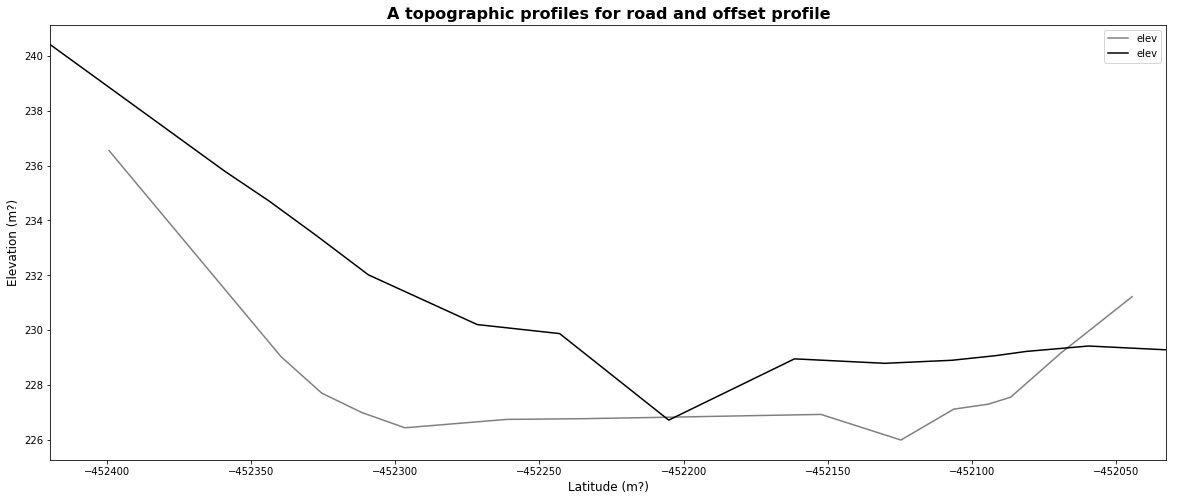

In [85]:
# Grab topographic data along lines
road_profile = get_topo_from_line(list(single_road.geometry)[0], dem)
left_offset_profile = get_topo_from_line(list(offset_lines.geometry)[0], dem)

# Showcase the results for Bess* road
fig, ax = plt.subplots(figsize = (20,8))
left_offset_profile.plot(x='lat',y='elev', color='k', alpha=0.5, ax=ax);
road_profile.plot(x='lat',y='elev', color='k', ax=ax);
ax.set_ylabel("Elevation (m?)", fontsize=12)
ax.set_xlabel("Latitude (m?)", fontsize=12)
ax.set_title("A topographic profiles for road and offset profile", fontsize=16, fontweight='bold');

In [86]:
# Outline basic workflow for choosing lats vs lons
def plot_lat_or_long(df:pd.core.frame.DataFrame, threshold:int) -> None:
    """Basic logic to determine if lats or lons should be plotted"""
    lats = [point.y for point in road_profile.point]
    delta_lat = max(lats) - min(lats)
    if delta_lat >= threshold:
        print("Use lats")
    else:
        print("Use lons")
        
plot_lat_or_long(road_profile, 100)

Use lats


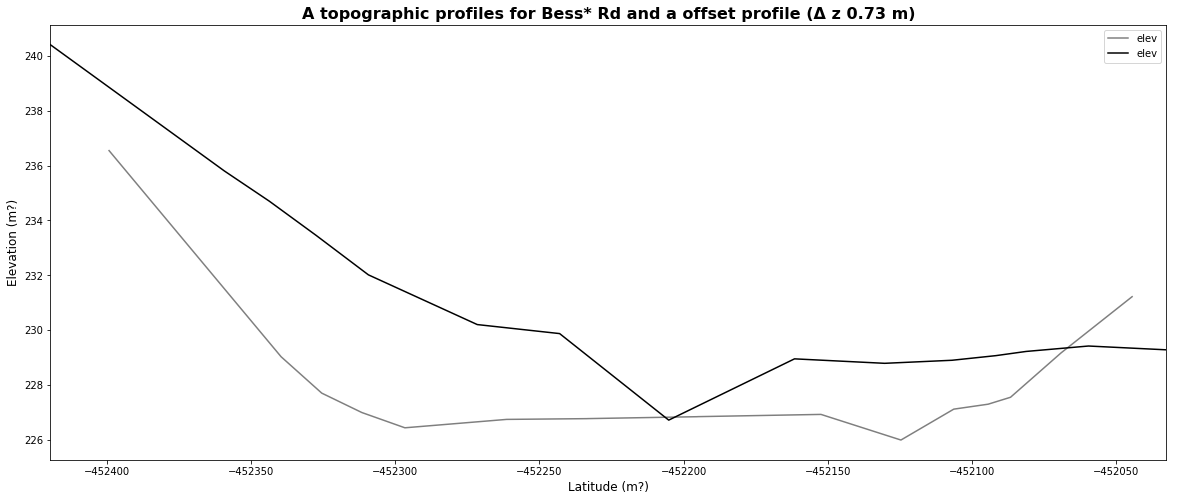

In [87]:
# Get the delta-elevation and report that for the profile
offset_min = min(left_offset_profile.elev)
road_min = min(road_profile.elev)
delta_z = round(road_min - offset_min, 2)

# Showcase the results for Bess* road
fig, ax = plt.subplots(figsize = (20,8))
left_offset_profile.plot(x='lat',y='elev', color='k', alpha=0.5, ax=ax);
road_profile.plot(x='lat',y='elev', color='k', ax=ax);
ax.set_ylabel("Elevation (m?)", fontsize=12)
ax.set_xlabel("Latitude (m?)", fontsize=12)
ax.set_title("A topographic profiles for Bess* Rd and a offset profile (\u0394 z {} m)".format(delta_z),
             fontsize=16, fontweight='bold');

In [88]:
# Set variables
window_size = 3
delta_threshold = 2

# Use a rolling median filter for every three points
road_profile['median'] = road_profile.elev.rolling(window_size).median()

# Drop NaNs and deltas above threshold
road_profile.dropna(inplace=True)
road_profile['z_delta'] = abs(road_profile['median'] - road_profile['elev'])
road_profile.drop(road_profile[road_profile['z_delta'] > delta_threshold].index, inplace=True)

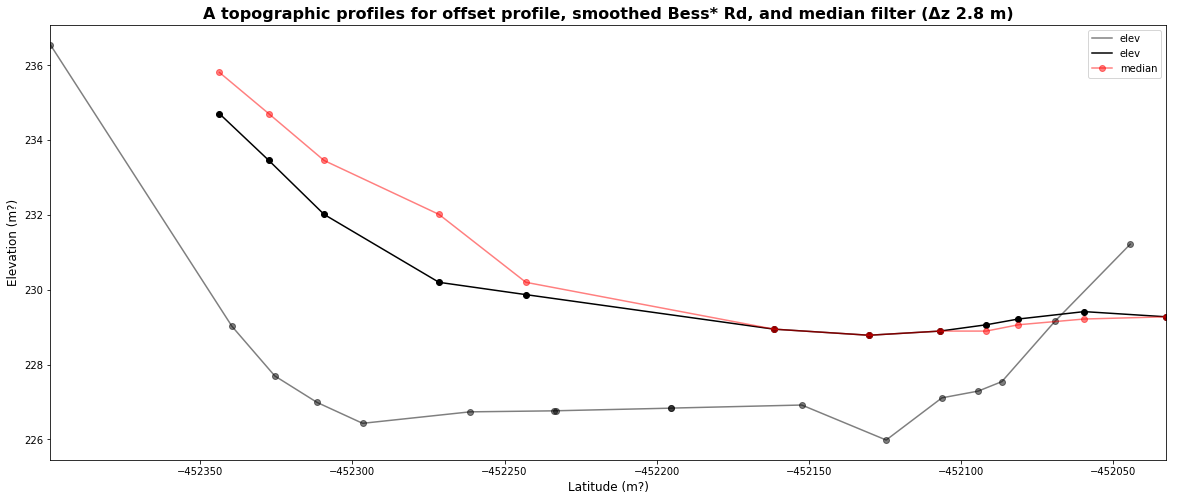

In [89]:
# Recalculated delta-elevation
offset_min = min(left_offset_profile.elev)
road_min = min(road_profile.elev)
delta_z = round(road_min - offset_min, 2)

# Show off results
fig, ax = plt.subplots(figsize = (20,8))

left_offset_profile.plot(x='lat',y='elev', color='k', marker='o', alpha=0.5, ax=ax);
road_profile.plot(x='lat',y='elev', color='k', marker='o', ax=ax);
road_profile.plot(x='lat',y='median', color='r', alpha=0.5, marker='o', ax=ax);

ax.set_ylabel("Elevation (m?)", fontsize=12)
ax.set_xlabel("Latitude (m?)", fontsize=12)
ax.set_title("A topographic profiles for offset profile, smoothed Bess* Rd, and median filter (\u0394z {} m)".format(delta_z),
             fontsize=16, fontweight='bold');

In [90]:
# Concatenate elevation values into points
pnts = []
for i in road_profile.index:
    row = road_profile.loc[i]
    x, y = list(row.point.coords)[0]
    z = row.elev
    pnts.append(Point([x, y, z]))
    
ls = LineString(pnts)

# Interpolate points
interp_pnts = []
for i in range(0, round(ls.length), 5):
    interp_pnts.append(ls.interpolate(i))
    
# Pull back into DataFrame for plotting
gdf_dense = pd.DataFrame(interp_pnts, columns=['point'])
gdf_dense['elev'] = gdf_dense.point.apply(lambda point: list(point.coords)[0][2])
gdf_dense['lat'] = gdf_dense.point.apply(lambda point: list(point.coords)[0][1])

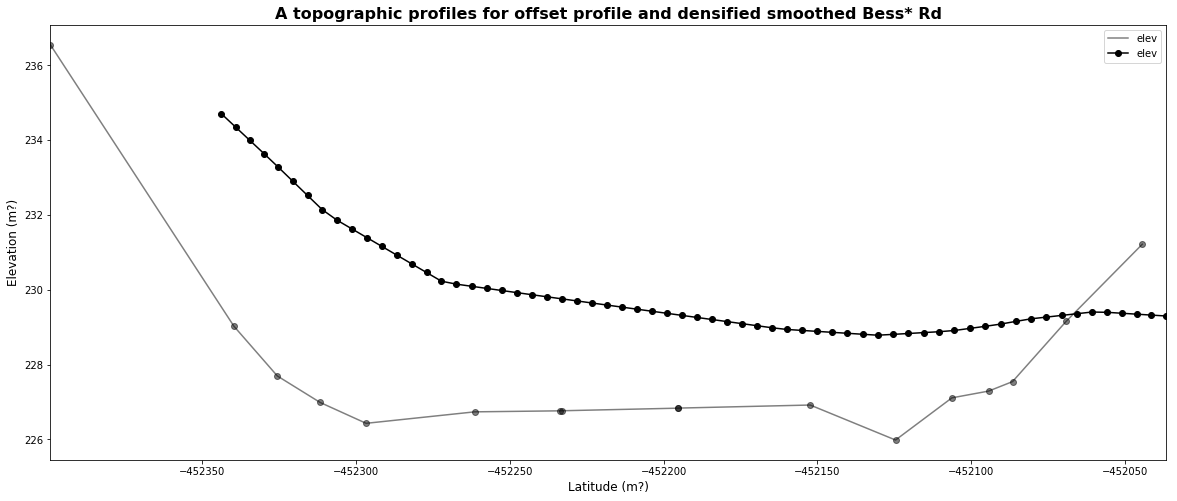

In [91]:
# Show off results
fig, ax = plt.subplots(figsize = (20,8))
left_offset_profile.plot(x='lat',y='elev', color='k', marker='o', alpha=0.5, ax=ax);
gdf_dense.plot(x='lat',y='elev', color='k', marker='o', ax=ax);

ax.set_ylabel("Elevation (m?)", fontsize=12)
ax.set_xlabel("Latitude (m?)", fontsize=12)
ax.set_title("A topographic profiles for offset profile and densified smoothed Bess* Rd",
             fontsize=16, fontweight='bold');

In [92]:
# Concatenate elevation values into points
pnts = []
for i in left_offset_profile.index:
    row = left_offset_profile.loc[i]
    x, y = list(row.point.coords)[0]
    z = row.elev
    pnts.append(Point([x, y, z]))
    
ls = LineString(pnts)

# Interpolate points
interp_pnts = []
for i in range(0, round(ls.length), 5):
    interp_pnts.append(ls.interpolate(i))
    
# Pull back into DataFrame for plotting
gdf_dense_offset = pd.DataFrame(interp_pnts, columns=['point'])
gdf_dense_offset['elev'] = gdf_dense_offset.point.apply(lambda point: list(point.coords)[0][2])
gdf_dense_offset['lat'] = gdf_dense_offset.point.apply(lambda point: list(point.coords)[0][1])

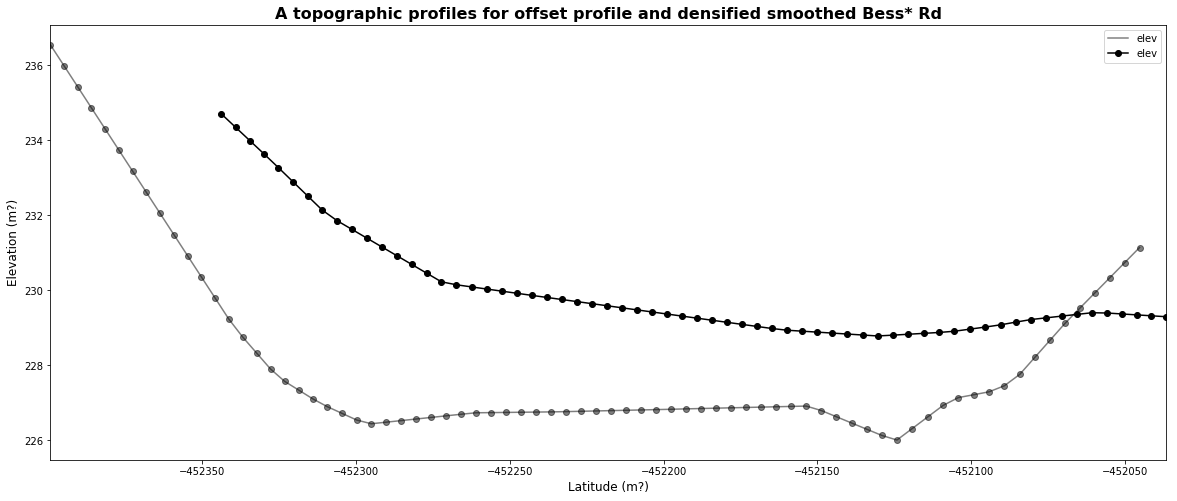

In [93]:
# Show off results
fig, ax = plt.subplots(figsize = (20,8))
gdf_dense_offset.plot(x='lat',y='elev', color='k', marker='o', alpha=0.5, ax=ax);
gdf_dense.plot(x='lat',y='elev', color='k', marker='o', ax=ax);

ax.set_ylabel("Elevation (m?)", fontsize=12)
ax.set_xlabel("Latitude (m?)", fontsize=12)
ax.set_title("A topographic profiles for offset profile and densified smoothed Bess* Rd",
             fontsize=16, fontweight='bold');